**Тестовое задание в команду продуктовой аналитики, Gett.**

В папке с заданием два датасета - data_orders - содержит выборку данных по заказам пользователей и включает такие колонки как:
* order_datetime -  время заказа
* origin_longitude - долгота
* origin_latitude - широта
* m_order_eta - время до прибытия машины
* order_gk - номер заказа
* order_status_key - статус (4 - отменен клиентом, 9 - отменен системой (reject))
* is_driver_assigned_key - был ли назначен водитель
* cancellations_time_in_seconds - сколько секунд прошло до отмены

data_offers - содержит пары номер заказа - ID оффера, который был предложен водителю по данному заказу.


В момент когда клиент нажимать на кнопку "Заказать" в приложении, система матчинга подыскивает наиболее релевантых водителей и предлагаем им заказ. В задании предлагается исследовать некоторые метрики матчинга для заказов, которые не завершились успешно (клиент в итоге не получил машину). 

## Подготовка

In [ ]:
!wget https://github.com/slgero/testovoe/raw/master/Gett/data/data_offers.csv
!wget https://github.com/slgero/testovoe/raw/master/Gett/data/data_orders.csv

--2023-02-22 11:52:18--  https://github.com/slgero/testovoe/raw/master/Gett/data/data_offers.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/slgero/testovoe/master/Gett/data/data_offers.csv [following]
--2023-02-22 11:52:18--  https://raw.githubusercontent.com/slgero/testovoe/master/Gett/data/data_offers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9027819 (8.6M) [text/plain]
Saving to: ‘data_offers.csv.2’

data_offers.csv.2   100%[===================>]   8.61M  --.-KB/s    in 0.08s   

2023-02-22 11:52:19 (103 MB/s) - ‘data_offers.csv.2’ saved [9027819/9027819]

--2023-02-22 11:52:19

## Решение

#### **0.** Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df= pd.read_csv('data_orders.csv')
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


#### **1.** Постройте распределение заказов по причинам неуспеха: отмены до и после назначения водителя, режекты

In [ ]:
df['reject_by_syst'] = df['order_status_key'].replace([4,9],[0,1])

In [ ]:
df.groupby('is_driver_assigned_key')['reject_by_syst'].mean().reset_index()

,is_driver_assigned_key,reject_by_syst
0,0,0.431030
1,1,0.001066


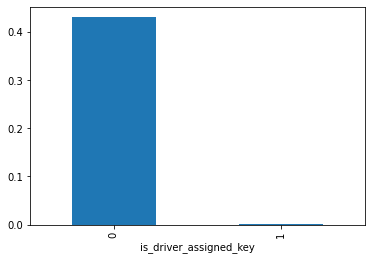

In [ ]:
df.groupby('is_driver_assigned_key')['reject_by_syst'].mean().plot(kind='bar')

Проанализируйте полученный график - в какой категории наибольшое количество заказов?

In [ ]:
df.groupby('is_driver_assigned_key')['reject_by_syst'].count()

is_driver_assigned_key
0    7902
1    2814
Name: reject_by_syst, dtype: int64

*Мы видим, что в случае, когда водитель не назначен, доля отказов (reject) системой составляет 43%. А в случае, когда водитель назначен, доля отказов - всего 1%. При этом количество заказов с неназначенным водителем боллее чем в 2 раза превышает количество заказов с назначенным водителем*

#### **2.** Постройте график распределения фейлов по часам - наблюдается ли тендеция, что в какие то часы доля той или иной категории аномально высока?

In [ ]:
df['hour'] = df['order_datetime'].str[:2]

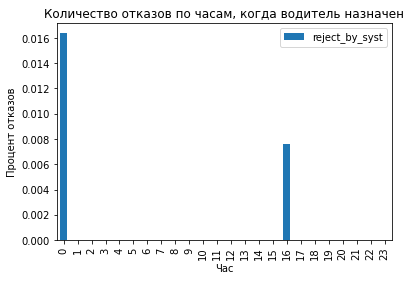

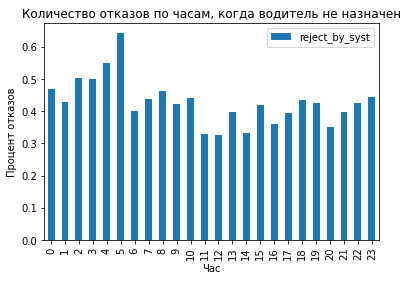

In [ ]:
df[df['is_driver_assigned_key']==1].groupby('hour')['reject_by_syst'].mean().reset_index().plot(kind='bar', title='Количество отказов по часам, когда водитель назначен', xlabel='Час', ylabel='Процент отказов')
df[df['is_driver_assigned_key']==0].groupby('hour')['reject_by_syst'].mean().reset_index().plot(kind='bar', title='Количество отказов по часам, когда водитель не назначен', xlabel='Час', ylabel='Процент отказов')
plt.show()

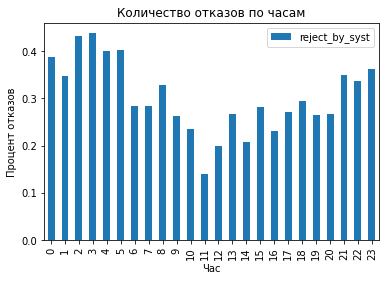

In [ ]:
df.groupby('hour')['reject_by_syst'].mean().reset_index().plot(kind='bar', title='Количество отказов по часам', xlabel='Час', ylabel='Процент отказов')

В какие часы фейлов больше всего? Чем это можно объяснить?

*В ночные часы доля заказов отмененных системой выше чем в дневные. Скорее всего это связано с недостаточным и меншьим количеством водителей, работающих ночью.*

#### **3**. Постройте графики среднего времени до отмены (cancellations_time_in_seconds) с водителем и без, по часам. Если есть выбросы в данных - лучше удалить. Можно ли сделать выводы по этому графику?

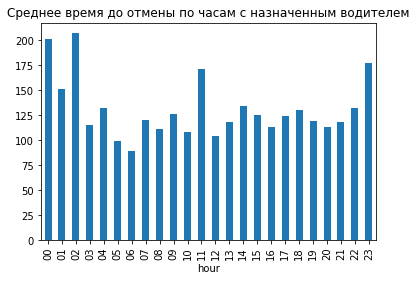

In [ ]:
df[df['is_driver_assigned_key']==1].groupby('hour')['cancellations_time_in_seconds'].median().plot(kind='bar', title='Среднее время до отмены по часам с назначенным водителем')

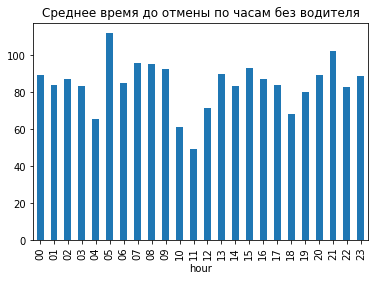

In [ ]:
df[df['is_driver_assigned_key']==0].groupby('hour')['cancellations_time_in_seconds'].median().plot(kind='bar', title='Среднее время до отмены по часам без водителя')

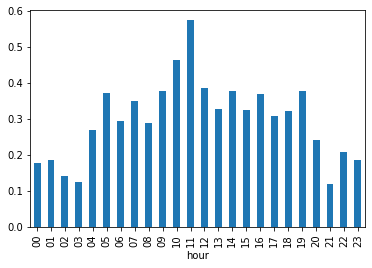

In [ ]:
df.groupby('hour')['is_driver_assigned_key'].mean().plot(kind='bar')

In [ ]:
df.groupby('is_driver_assigned_key')['cancellations_time_in_seconds'].agg(['count','mean','median'])

,count,mean,median
is_driver_assigned_key,,,
0,4496,110.371441,88.0
1,2811,233.897901,127.0


*Если водитель не назначен, то среднее время до отмены значительно ниже *

#### **4.** Постройте распределение среднего ЕТА по часам. Чем можно объяснить такой вид графика?

In [ ]:
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,reject_by_syst,hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,0,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,0,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,0,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,0,13
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,1,21


In [ ]:
df['m_order_eta']=df.m_order_eta.fillna(0)


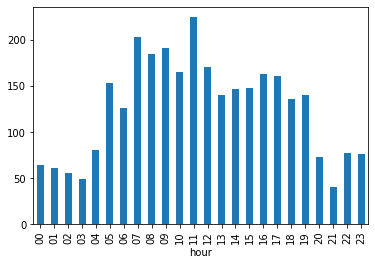

In [ ]:
df.groupby('hour')['m_order_eta'].mean().plot(kind='bar')

*Среднее время до прибытия машины выше в дневные часы, что может быть связано с повышенным трафиком и пробками*

#### 5 Колонка drivers_offered - показывает сколько водителей увидели заказ и могли его принять. Постройте часовую разбивку среднего количества водителей которым был предложен заказ. Что можно сказать по ней про избыток/нехватку водителей в те или иные часы?

In [ ]:
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,reject_by_syst,hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,0,18
1,20:57:32,-0.950385,51.456843,0.0,3000583116437,4,0,128.0,0,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,0,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,0,13
4,21:24:45,-0.967605,51.458236,0.0,3000583140877,9,0,NaN,1,21


In [ ]:
offers = pd.read_csv('data_offers.csv').groupby('order_gk')['offer_id'].count().reset_index()
offers

,order_gk,offer_id
0,3000551431542,1
1,3000551431560,2
2,3000551431566,5
3,3000551431577,2
4,3000551431592,7
...,...,...
97962,3000633196069,2
97963,3000633196079,1
97964,3000633196163,7
97965,3000633196174,2


In [ ]:
df = df.merge(offers, how='left', on='order_gk')
df

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,reject_by_syst,hour,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,0,18,1.0
1,20:57:32,-0.950385,51.456843,0.0,3000583116437,4,0,128.0,0,20,3.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,0,12,6.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,0,13,3.0
4,21:24:45,-0.967605,51.458236,0.0,3000583140877,9,0,NaN,1,21,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10711,13:11:35,-0.975372,51.457846,0.0,3000599186906,4,0,36.0,0,13,1.0
10712,13:13:55,-0.975372,51.457846,0.0,3000599186962,4,0,4.0,0,13,NaN
10713,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0,0,13,1.0
10714,13:16:28,-0.975372,51.457846,0.0,3000599187024,4,0,6.0,0,13,NaN


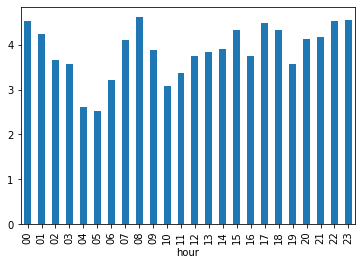

In [ ]:
df.groupby('hour')['offer_id'].mean().plot(kind='bar')

*Распределение по часам кол-во водитилей увидевших заказ практически равномерное. Исключение составляют 4 и 5 час утра: идет просадка в 2 раза, но это и самое неактивное время по кол-ву заказов.*

#### **6*.** Гексаконы.


Воспользовавшись пакетами h3 и folium, посчитайте, сколько гексагонов размера 8 (https://uber.github.io/h3/#/documentation/core-library/resolution-table) содержат 80% всех заказов из исходного датасета и визуализируйте гексагон с наибольшим количеством фейлов на карте.

In [ ]:
! pip install h3
import h3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def get_geksagon(row):
  return h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], 8)

In [ ]:
df['geksagon'] = df.apply(get_geksagon,axis=1)

In [ ]:
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,reject_by_syst,hour,offer_id,geksagon
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,0,18,1.0,88195d2b03fffff
1,20:57:32,-0.950385,51.456843,0.0,3000583116437,4,0,128.0,0,20,3.0,88195d2b19fffff
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,0,12,6.0,88195d2b1dfffff
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,0,13,3.0,88195d7497fffff
4,21:24:45,-0.967605,51.458236,0.0,3000583140877,9,0,NaN,1,21,NaN,88195d2b1dfffff


In [ ]:
geksagon = df['geksagon'].value_counts().reset_index()
geksagon

,index,geksagon
0,88195d2b1dfffff,1497
1,88195d2b1bfffff,870
2,88195d2b15fffff,774
3,88195d2b11fffff,707
4,88195d2b19fffff,667
...,...,...
139,88195d2821fffff,1
140,88195d3993fffff,1
141,88195d2b69fffff,1
142,88195d74d5fffff,1


In [ ]:
(geksagon['geksagon'].cumsum() / geksagon['geksagon'].sum()).head(30)

0     0.139698
1     0.220885
2     0.293113
3     0.359089
4     0.421333
5     0.482270
6     0.520903
7     0.555618
8     0.589399
9     0.621687
10    0.645670
11    0.665267
12    0.682437
13    0.699421
14    0.713979
15    0.728257
16    0.741601
17    0.753266
18    0.763998
19    0.773143
20    0.781728
21    0.790220
22    0.798152
23    0.805711
24    0.813177
25    0.820642
26    0.827548
27    0.833987
28    0.840332
29    0.846491
Name: geksagon, dtype: float64

Ответ - 23 гексагонов

In [ ]:
df.groupby('geksagon')['reject_by_syst'].agg({'mean', 'count','sum'}).sort_values(by = 'count', ascending = False)

,sum,mean,count
geksagon,,,
88195d2b1dfffff,358,0.239145,1497
88195d2b1bfffff,256,0.294253,870
88195d2b15fffff,198,0.255814,774
88195d2b11fffff,225,0.318246,707
88195d2b19fffff,182,0.272864,667
...,...,...,...
88195d281dfffff,0,0.000000,1
88195d2821fffff,0,0.000000,1
88195d2a1bfffff,0,0.000000,1


88195d2b1dfffff - гексагон с наиболшим количеством фейлов

In [ ]:
coordinatess = df[df['geksagon']== '88195d2b1dfffff'][['origin_latitude','origin_longitude']].reset_index(drop = True)

In [ ]:
coordinatess

,origin_longitude,origin_latitude
0,-0.969520,51.455544
1,-0.967605,51.458236
2,-0.972037,51.456781
3,-0.973763,51.458671
4,-0.971564,51.458022
...,...,...
1492,-0.971480,51.458364
1493,-0.973398,51.458384
1494,-0.972926,51.457693
1495,-0.972926,51.457693


**Отбразим наш гексагон на карте с помощью тепловой карты (с учётом всех заявок, и отказов и принятых)**

In [53]:
import folium
from folium import plugins
from folium.plugins import HeatMap

m = folium.Map(location=[51.458,-0.9655], zoom_start=15)
heat_data = [[row['origin_latitude'],row['origin_longitude']] for index, row in coordinatess.iterrows()]

HeatMap(heat_data).add_to(m)
m

#### Дополнительно (моё)

**Мне стало интересно построить карту отображения всех фейлов на карте**

In [ ]:
dff = df[df['reject_by_syst']==1][['origin_longitude','origin_latitude']]

In [ ]:
m = folium.Map(location=[51.458,-0.9655], zoom_start=12)
heat_data = [[row['origin_latitude'],row['origin_longitude']] for index, row in dff.iterrows()]

HeatMap(heat_data).add_to(m)
m